In [1]:
#######################################################################
#######################################################################
######################### Importing Packages ##########################
#######################################################################
#######################################################################

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf
import math
from datetime import datetime, timedelta
import scipy.stats

# need to clean these up later
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Activation, Input, Dense, LSTM, concatenate
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
tfd = tfp.distributions

from numpy.random import rand
from numpy import ix_
np.random.seed(1337)

In [2]:
ARMAGARCH = pd.read_csv("C:/Warwick Final Year/RAE/Processed Data/ARMAGARCH.csv")

In [3]:
ARMAGARCH.head()

,Date,Norm_mu,Norm_std,T_mu,T_std,Lap_mu,Lap_std
0,2015-01-05,0.000464,0.012011,0.000508,0.012597,-0.000747,0.010490
1,2015-01-06,-0.000566,0.017125,-0.000023,0.015428,-0.000480,0.009185
2,2015-01-07,0.000749,0.014458,0.000728,0.015393,-0.001417,0.015970
3,2015-01-08,0.000956,0.014687,0.000624,0.014701,-0.000914,0.014468
4,2015-01-09,0.001093,0.012545,0.000995,0.013777,0.000336,0.013130


In [4]:
#######################################################################
#######################################################################
###################### Data Importing/Cleaning ########################
#######################################################################
#######################################################################

# import data and calculate log returns from adjusted close
df_Nikkei_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^N225.csv")
df_NASDAQ_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^IXIC.csv")
df_DAX_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^GDAXI.csv")

In [5]:
def Data_Processor(DATA,
                   Batch_Size,
                   Length_of_Batch,
                   Test_Train_Split):
    
    DATA.columns = [c.replace(' ', '_') for c in DATA.columns]
    DATA = DATA[DATA['Adj_Close'].notnull()]
    DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))

    # spilt to training and test sets
    DATA    = DATA[['Date','log_ret']][1:]
    DATA['Date'] = DATA['Date'].apply(pd.Timestamp)
    DATA.set_index('Date',inplace=True, drop=True)
    
    train = DATA.loc[:Test_Train_Split]
    test  = DATA.loc[Test_Train_Split:]
   
    DATA_train = [[i] for i in train['log_ret']]
    DATA_test  = [[i] for i in test['log_ret']]
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    
    # creating time series generator for processing
    # make one for training, one for validation
    time_series_generator = TimeseriesGenerator(DATA_train, 
                                                DATA_train, 
                                                length=Length_of_Batch, 
                                                batch_size=Batch_Size)
    time_series_val_generator = TimeseriesGenerator(DATA_test,
                                                    DATA_test, 
                                                    length=Length_of_Batch, 
                                                    batch_size=Batch_Size)

    
    return {"Data" : DATA,
            "Training" : time_series_generator,
            "Validation" : time_series_val_generator}



In [6]:
Batch_Size = 64
Length     = 25
Test_Train_Split = '2015-01-01'

Nikkei = Data_Processor(df_Nikkei_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)
NASDAQ = Data_Processor(df_NASDAQ_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)
DAX = Data_Processor(df_DAX_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)

<ipython-input-5-2335be0e7533>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))
<ipython-input-5-2335be0e7533>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))


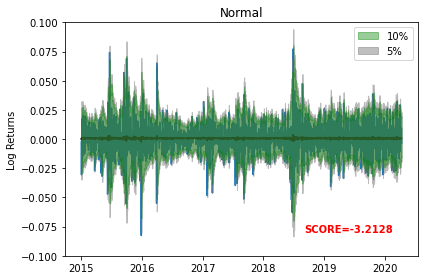

In [7]:
# first the normal distribution
means = ARMAGARCH['Norm_mu']
scale   = ARMAGARCH['Norm_std']

x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'], color='#1f77b4',zorder=1)

ppf = scipy.stats.norm.ppf
         
SCORE = -round(np.sum(np.log(scipy.stats.norm.pdf(Nikkei['Data'].loc['2015-01-01':]['log_ret'],
                                         loc = means,
                                         scale = scale)))/len(Nikkei['Data'].loc['2015-01-01':]['log_ret']),4)
NAME = "Normal"
         
s1 = plt.fill_between(x,np.add(means,ppf(0.95,loc=means,scale=scale)),
                      np.add(means,ppf(0.05,loc=means,scale=scale)), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,loc=means,scale=scale)),
                 np.add(means,ppf(0.025,loc=means,scale=scale)), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_ARMAGARCH555' + 'Normal' + '.pdf')

plt.show()

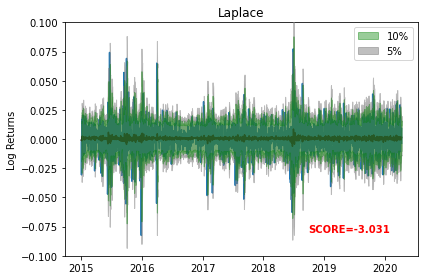

In [8]:
# next the Laplace
means = ARMAGARCH['Lap_mu']
scale   = np.divide(ARMAGARCH['Lap_std'],np.sqrt(2))

x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'], color='#1f77b4',zorder=1)

ppf = scipy.stats.laplace.ppf
         
SCORE = -round(np.sum(np.log(scipy.stats.laplace.pdf(Nikkei['Data'].loc['2015-01-01':]['log_ret'],
                                         loc = means,
                                         scale = scale)))/len(Nikkei['Data'].loc['2015-01-01':]['log_ret']),4)
NAME = "Laplace"
         
s1 = plt.fill_between(x,np.add(means,ppf(0.95,loc=means,scale=scale)),
                      np.add(means,ppf(0.05,loc=means,scale=scale)), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,loc=means,scale=scale)),
                 np.add(means,ppf(0.025,loc=means,scale=scale)), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_ARMAGARCH555' + 'Laplace' + '.pdf')

plt.show()

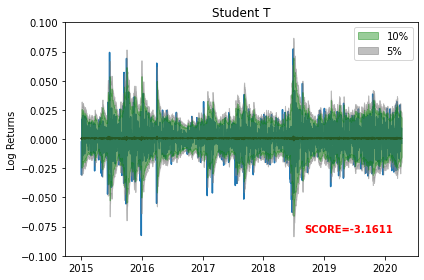

In [9]:
# finally the t-distribution
# the DoF are set when fitting the model, then the scale and location parameters vary over forecasts

shape = 5.867205 # need to change to not be hardcoded in


means = ARMAGARCH['T_mu']

scale   = np.divide(ARMAGARCH['T_std'],np.sqrt(shape/(shape-2)))

x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'], color='#1f77b4',zorder=1)

ppf = scipy.stats.t.ppf
         
SCORE = -round(np.sum(np.log(scipy.stats.t.pdf(Nikkei['Data'].loc['2015-01-01':]['log_ret'],
                                         df= shape,
                                         loc = means,
                                         scale = scale)))/len(Nikkei['Data'].loc['2015-01-01':]['log_ret']),4)
NAME = "Student T"
         
s1 = plt.fill_between(x,np.add(means,ppf(0.95,df=shape,loc=means,scale=scale)),
                      np.add(means,ppf(0.05,df=shape,loc=means,scale=scale)), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,df=shape,loc=means,scale=scale)),
                 np.add(means,ppf(0.025,df=shape,loc=means,scale=scale)), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_ARMAGARCH555' + 'Student T' + '.pdf')

plt.show()